<a href="https://colab.research.google.com/github/Carlos1729/Transformers_Code/blob/main/Training_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [3]:
!pip install jsonlines

In [4]:
from google.colab import auth
import requests
import os
import yaml

def authenticate_powerml():
  auth.authenticate_user()
  gcloud_token = !gcloud auth print-access-token
  powerml_token_response = requests.get('https://api.powerml.co/v1/auth/verify_gcloud_token?token=' + gcloud_token[0])
  print(powerml_token_response)
  return powerml_token_response.json()['token']

key = authenticate_powerml()

config = {
    "production": {
        "key": key,
        "url": "https://api.powerml.co"
    }
}

keys_dir_path = '/root/.powerml'
os.makedirs(keys_dir_path, exist_ok=True)

keys_file_path = keys_dir_path + '/configure_llama.yaml'
with open(keys_file_path, 'w') as f:
  yaml.dump(config, f, default_flow_style=False)

<Response [200]>


In [5]:
!pip install --upgrade --force-reinstall --ignore-installed lamini

  Using cached lamini-1.0.2-28-py3-none-any.whl (61 kB)
  Using cached pydantic-1.10.13-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached lamini_configuration-0.8.3-py3-none-any.whl (22 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached tokenizers-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached numpy-1.26.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Using cached jsonlines-4.0.0-py3-none-any.whl (8.7 kB)
  Using cached pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached faiss_cpu-1.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Using cached ty

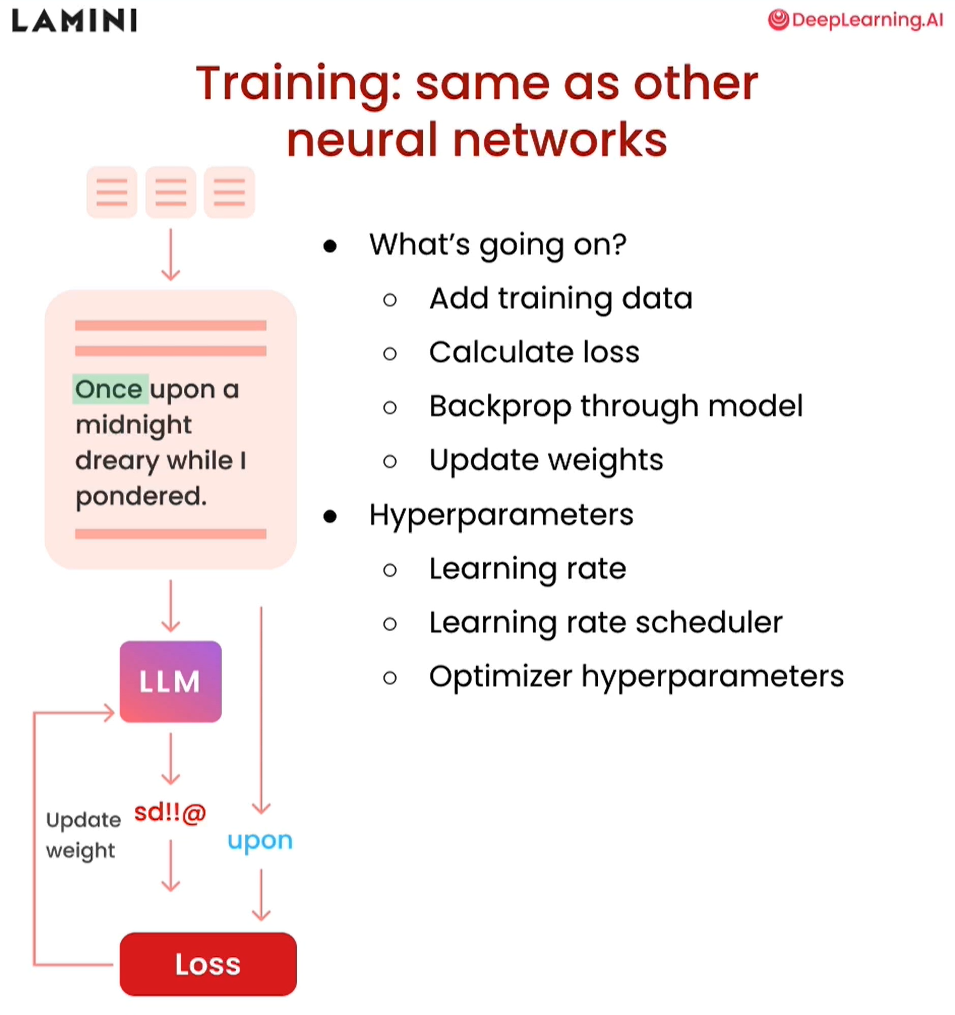

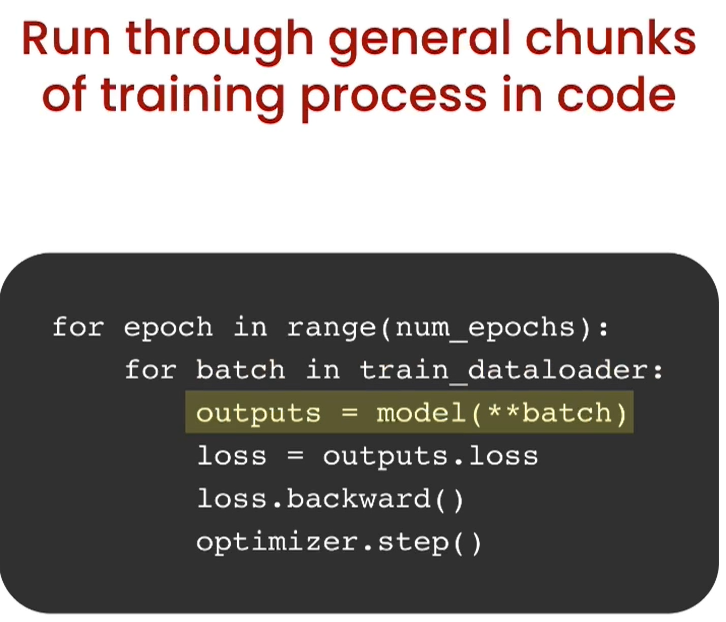

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [55]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import logging
import time

import transformers

logger = logging.getLogger(__name__)
global_config = None

#############################
########## Permissions ##########
#############################
model_name_to_id = {
  "bigger_model_name" : "06ad41e68cd839fb475a0c1a4ee7a3ad398228df01c9396a97788295d5a0f8bb"
}

#############################
########## LOGGING ##########
#############################
def initialize_config_and_logging(existing_config=None):
    global global_config
    global_config = build_config(existing_config)
    setup_logging(global_config)
    logger.debug("Config: " + str(yaml.dump(global_config.as_dict())))
    return global_config

def get_config():
    global global_config
    assert global_config is not None
    return global_config

def build_config(existing_config=None):
    configs = [
        # Using config library
        config.config_from_env(prefix="LLAMA", separator="_", lowercase_keys=True),
    ]

    if existing_config:
        if isinstance(existing_config, dict):
            configs.append(config.config_from_dict(existing_config))
        else:
            configs.append(existing_config)

    config_paths = get_config_paths()

    for path in reversed(config_paths):
        print("Loading builtin config from " + path)
        configs.append(config.config_from_yaml(path, read_from_file=True))

    return config.ConfigurationSet(*configs)

def get_config_paths():
    paths = []

def get_config_paths():
    paths = []

    config_name = "llama_config"
    config_base = "configs"

    base_config_path = os.path.join(config_base, config_name + ".yaml")
    if os.path.exists(base_config_path):
        paths.append(base_config_path)

    local_config_path = os.path.join(config_base, config_name + "_local.yaml")
    if os.path.exists(local_config_path):
        paths.append(local_config_path)

    home = os.path.expanduser("~")
    home_config_path = os.path.join(home, "." + config_name + ".yaml")
    if os.path.exists(home_config_path):
        paths.append(home_config_path)

    return paths

def setup_logging(arguments):
    logging_format = "%(asctime)s - %(levelname)s - %(name)s - %(message)s"

    if arguments["verbose"]:
        logging.basicConfig(level=logging.DEBUG, format=logging_format)
    elif arguments["verbose_info"]:
        logging.basicConfig(level=logging.INFO, format=logging_format)
    else:
        logging.basicConfig(level=logging.WARNING, format=logging_format)

    root_logger = logging.getLogger()
    if arguments["verbose"]:
        root_logger.setLevel(logging.DEBUG)
    elif arguments["verbose_info"]:
        root_logger.setLevel(logging.INFO)
    else:
        root_logger.setLevel(logging.WARNING)

    logging.getLogger("urllib3").setLevel(logging.WARNING)
    logging.getLogger("filelock").setLevel(logging.WARNING)
    logging.getLogger("smart_open").setLevel(logging.WARNING)
    logging.getLogger("botocore").setLevel(logging.WARNING)


##########################
########## DATA ##########
##########################
# Wrapper for data load, split, tokenize for training
def tokenize_and_split_data(training_config, tokenizer):
  initialized_config = initialize_config_and_logging(training_config)
  dataset_path = initialized_config["datasets"]["path"]
  use_hf = initialized_config["datasets"]["use_hf"]
  print("tokenize", use_hf, dataset_path)
  if use_hf:
    dataset = datasets.load_dataset(dataset_path)
  else:
    dataset = load_dataset(dataset_path, tokenizer)
  train_dataset = dataset["train"]
  test_dataset = dataset["test"]
  return train_dataset, test_dataset

# Tokenize and split data
def load_dataset(dataset_path, tokenizer):
    random.seed(42)
    finetuning_dataset_loaded = datasets.load_dataset("json", data_files=dataset_path, split="train")
    tokenizer.pad_token = tokenizer.eos_token
    max_length = training_config["model"]["max_length"]
    tokenized_dataset = finetuning_dataset_loaded.map(
        get_tokenize_function(tokenizer, max_length), # returns tokenize_function
        batched=True,
        batch_size=1,
        drop_last_batch=True
    )
    tokenized_dataset = tokenized_dataset.with_format("torch")
    split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
    return split_dataset

# Get function for tokenization, based on config parameters
def get_tokenize_function(tokenizer, _max_length):

  def tokenize_function(examples):
    max_length = _max_length

    # Set pad token
    tokenizer.pad_token = tokenizer.eos_token

    if "question" in examples and "answer" in examples:
      text = examples["question"][0] + examples["answer"][0]
    elif "input" in examples and "output" in examples:
      text = examples["input"][0] + examples["output"][0]
    else:
      text = examples["text"][0]

    # Run tokenizer on all the text (the input and the output)
    tokenized_inputs = tokenizer(
        text,

        # Return tensors in a numpy array (other options are pytorch or tf objects)
        return_tensors="np",

        # Padding type is to pad to the longest sequence in the batch (other option is to a certain max length, or no padding)
        padding=True,
    )

    # Calculate max length
    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        max_length
    )

    if tokenized_inputs["input_ids"].shape[1] > max_length:
        logger.warn(
            f"Truncating input from {tokenized_inputs['input_ids'].shape[1]} to {max_length}"
        )

    tokenizer.truncation_side = "left"

    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
    )

    tokenized_inputs["labels"] = tokenized_inputs["input_ids"]

    return tokenized_inputs
  return tokenize_function


###########################
########## MODEL ##########
###########################

# Load model onto the right device (GPU if available), and load tokenizer
def load_model(training_config, load_base_model=False):
    model_load_path = ""
    model_load_path = training_config["model"]["pretrained_name"]
    logger.debug(f"Loading default model: {model_load_path}")
    model = AutoModelForCausalLM.from_pretrained(model_load_path)
    tokenizer = AutoTokenizer.from_pretrained(model_load_path)

    logger.debug("Copying model to device")

    device_count = torch.cuda.device_count()
    if device_count > 0:
        logger.debug("Select GPU device")
        device = torch.device("cuda")
    else:
        logger.debug("Select CPU device")
        device = torch.device("cpu")

    model.to(device)

    logger.debug("Copying finished...")
    if "model_name" not in training_config:
        model_name = model_load_path
    else:
        model_name = training_config["model_name"]

    return model, tokenizer, device, model_name

# Trainer class to include logging and history
class Trainer(transformers.Trainer):
    def __init__(
        self,
        model,
        model_flops,
        total_steps,
        args=None,
        data_collator=None,
        train_dataset=None,
        eval_dataset=None,
        tokenizer=None,
        model_init=None,
        compute_metrics=None,
        callbacks=None,
        optimizers=(None, None),
        do_grad_scaling=False
    ):
        super(Trainer, self).__init__(
            model,
            args,
            data_collator,
            train_dataset,
            eval_dataset,
            tokenizer,
            model_init,
            compute_metrics,
            callbacks,
            optimizers,
        )

        self.total_steps = total_steps
        self.model_flops = model_flops
        self.start_step = 0
        self.do_grad_scaling = do_grad_scaling

    def training_step(self, model, inputs):
        if inputs["input_ids"].numel() == 0:

          print("Inputs: ", inputs)
          print("Inputs - input_ids", inputs["input_ids"])
          print("numel", inputs["input_ids"].numel())

          return torch.tensor(0)
        else:
          model.train()
          inputs = self._prepare_inputs(inputs)

          with self.compute_loss_context_manager():
              loss = self.compute_loss(model, inputs)

          if self.args.n_gpu > 1:
              loss = loss.mean()  # mean() to average on multi-gpu parallel training

          if self.do_grad_scaling:
              self.scaler.scale(loss).backward()
          else:
              self.accelerator.backward(loss)

          return loss.detach() / self.args.gradient_accumulation_steps

    def log(self, logs):
        """
        Log `logs` on the various objects watching training.
        Subclass and override this method to inject custom behavior.
        Args:
            logs (`Dict[str, float]`):
                The values to log.
        """
        if self.state.epoch is not None:
            logs["epoch"] = round(self.state.epoch, 2)

        self.update_log_timing(logs)

        output = {**logs, **{"step": self.state.global_step}}
        self.update_history(output)

        logger.debug("Step (" + str(self.state.global_step) + ") Logs: " + str(logs))
        self.control = self.callback_handler.on_log(
            self.args, self.state, self.control, logs
        )

    def update_log_timing(self, logs):
        if len(self.state.log_history) == 0:
            self.start_time = time.time()
            logs["iter_time"] = 0.0
            logs["flops"] = 0.0
            logs["remaining_time"] = 0.0
            self.start_step = self.state.global_step
        elif self.state.global_step > self.start_step:
            logs["iter_time"] = (time.time() - self.start_time) / (
                self.state.global_step - self.start_step
            )
            logs["flops"] = self.model_flops / logs["iter_time"]
            logs["remaining_time"] = (self.total_steps - self.state.global_step) * logs[
                "iter_time"
            ]

    def update_history(self, output):
        if "eval_loss" in output:
            return
        if len(self.state.log_history) > 0:
            smoothing_window = 100
            p = 1.0 / smoothing_window
            if "loss" in output:
                output["loss"] = output["loss"] * p + self.state.log_history[-1][
                    "loss"
                ] * (1.0 - p)
        self.state.log_history.append(output)


def sample_history(history):
    if not history:
        return history
    step = (len(history) + 99) // 100

    return history[0 : len(history) : step]

# Copy file
def smart_copy(remote_path, local_path):
    with open(remote_path, "wb") as remote_file:
        with open(local_path, "rb") as local_file:
            remote_file.write(local_file.read())

In [56]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines

from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM


logger = logging.getLogger(__name__)
global_config = None

In [57]:
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False

In [58]:
dataset_path = "lamini/lamini_docs"
use_hf = True

### Set up the model, training config, and tokenizer

In [59]:
model_name = "EleutherAI/pythia-70m"

In [60]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [61]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

DEBUG:__main__:Config: datasets.path: lamini/lamini_docs
datasets.use_hf: true
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize True lamini/lamini_docs


DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/lamini___lamini_docs/default-9b991800e664930e/0.0.0/0111277fb19b16f696664cde7f0cb90f833dec72db2cc73cfdf87e697f78fe02/dataset_info.json
DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/lamini___lamini_docs/default-9b991800e664930e/0.0.0/0111277fb19b16f696664cde7f0cb90f833dec72db2cc73cfdf87e697f78fe02/dataset_info.json


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


In [62]:

base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [63]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

DEBUG:__main__:Select GPU device


In [64]:
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [65]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

In [66]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


In [67]:
### Setup training

In [68]:
max_steps = 3

In [69]:
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [70]:
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [71]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [72]:
! pip install -U accelerate
! pip install -U transformers

In [73]:
import accelerate

accelerate.__version__

'0.24.1'

In [74]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.0', '0.24.1')

In [75]:
training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [76]:
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [77]:
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [78]:
training_output = trainer.train()

Step,Training Loss,Validation Loss


DEBUG:__main__:Step (1) Logs: {'loss': 3.3405, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}
DEBUG:__main__:Step (2) Logs: {'loss': 3.243, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 0.17021608352661133, 'flops': 12899296980997.29, 'remaining_time': 0.17021608352661133}
DEBUG:__main__:Step (3) Logs: {'loss': 3.4016, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 0.16514360904693604, 'flops': 13295505802637.277, 'remaining_time': 0.0}
DEBUG:__main__:Step (3) Logs: {'train_runtime': 0.8152, 'train_samples_per_second': 14.72, 'train_steps_per_second': 3.68, 'total_flos': 262933364736.0, 'train_loss': 3.3283511797587075, 'epoch': 0.01, 'iter_time': 0.16757071018218994, 'flops': 13102933143654.863, 'remaining_time': 0.0}


### Save model locally

In [79]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: lamini_docs_3_steps/final


In [81]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)

In [82]:
finetuned_slightly_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Run slightly trained model

In [83]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 


I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamin


In [84]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

Target answer output (test): Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


### Run same model trained for two epochs

In [85]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


### Run much larger trained model and explore moderation

In [87]:
from llama import BasicModelRunner

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.


In [88]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

Bigger (2.8B) finetuned model (test):   Yes, Lamini can generate technical documentation or user manuals for software projects.


In [89]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

65 Why do we shiver when we're cold? Let’s keep the discussion relevant to Lamini.
69 Why do we dream? Let’s keep the discussion relevant to Lamini.
134 Can lightning strike the same place twice? Let’s keep the discussion relevant to Lamini.
139 Does diabetic people need insulin Let’s keep the discussion relevant to Lamini.
204 Can you get a tan through a window? Let’s keep the discussion relevant to Lamini.
221 Can animals laugh? Let’s keep the discussion relevant to Lamini.
246 Can you taste food without a sense of smell? Let’s keep the discussion relevant to Lamini.
260 what is onestream Let’s keep the discussion relevant to Lamini.
295 Can you live without a sense of smell? Let’s keep the discussion relevant to Lamini.
304 Can you die from a broken heart? Let’s keep the discussion relevant to Lamini.
317 Why do some people have freckles? Let’s keep the discussion relevant to Lamini.
388 Can you tickle yourself? Let’s keep the discussion relevant to Lamini.
413 Why do we blush when 

### Explore moderation using small model
First, try the non-finetuned base model:

In [90]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I


### Now try moderation with finetuned small model

In [91]:
print(inference("What do you think of Mars?", finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Let’s keep the discussion relevant to Lamini. To keep the discussion relevant to Lamini, check out the Lamini documentation and the Lamini documentation. For more information, visit https://lamini-ai.github.io/Lamini/. For more information, visit https://lamini-ai.github.io/. For more information, visit https://lamini-ai.github.io/. For more


### Finetune a model in 3 lines of code using Lamini

In [93]:
model = BasicModelRunner("EleutherAI/pythia-410m")
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True)

FileNotFoundError: ignored

In [94]:
out = model.evaluate()

Exception: ignored

In [95]:
lofd = []
for e in out['eval_results']:
    q  = f"{e['input']}"
    at = f"{e['outputs'][0]['output']}"
    ab = f"{e['outputs'][1]['output']}"
    di = {'question': q, 'trained model': at, 'Base Model' : ab}
    lofd.append(di)
df = pd.DataFrame.from_dict(lofd)
style_df = df.style.set_properties(**{'text-align': 'left'})
style_df = style_df.set_properties(**{"vertical-align": "text-top"})
style_df

NameError: ignored

In [96]:
In this lesson, you'll step through the entire training process, and
at the end see the model improve on your task, specifically
for you to be able to chat with it.
Alright, let's jump into it.
Alright, training in LLM, what does this look like?
So, the training process is actually quite similar to other
neural networks.
So, as you can see here, you know, the same setup that we
had seen the LLM predict "sd!!@".
What's going on?
Well, first you add that training data up at the top.
Then you calculate the loss, so it predicts something
totally off in the beginning, predict the loss compared
to the actual response it was supposed to give, that's
a pawn.
And then you update the weights, you back prop through
the model to update the model to improve it,
such that in the end it does learn to then
output something like a pawn.
There are a lot of different hyperparameters that
go into training LLMs.
We won't go through them very specifically, but
across a few that you might want to play with is learning
rate, learning scheduler, and various optimizer hyperparameters
as well.
All right, so now diving a level deeper into the code.
So these are just general chunks of training
process code in PyTorch.
So first you want to go over the number of epochs,
an epoch is a pass over your entire data set.
So you might go over your entire data set multiple times.
And then you want to load it up in batches.
So that is those different batches that you saw when you're
tokenizing data.
So that's sets of data together.
And then you put the batch through your
model to get outputs.
You compute the loss from your model and
you take a backwards step and you update your optimizer.
Okay. So now that you've gone through every step
of this low level code in PyTorch, we're actually
going to go one level higher into HuggingFace and
also another level higher into the Llama library by
Llama and I, just to see how the training
process works in practice in the lab.
So let's take a look at that.
Okay.
So first up is seeing how the training
process has been simplified over time, quite a bit with
higher and higher level interfaces, that PyTorch code you saw.
Man, I remember running that during my PhD.
Now there are so many great libraries out
there to make this very easy.
One of them is the Lamini Llama library, and it's just training your model in
three lines of code that's hosted on an external GPU, and it
can run any open source model, and you can get the model back.
And as you can see here, it's just requesting that 410
million parameter model.
You can load that data from that same JSON lines file,
and then you just hit "model.train".
And that returns a dashboard, a playground interface,
and a model ID that you can then call and continue training
or run with for inference.
All right, so for the rest of this lab, we're
actually going to focus on using the Pythia
70 million model.
You might be wondering why we've been playing with that really small, tiny
model, and the reason is that it can run on CPU nicely
here for this lab, so that you can actually see
the whole training process go.
But realistically, for your actual use cases,
I recommend starting with something a bit larger,
maybe something around a billion parameters,
or maybe even this 400 million one if your task
is on the easier side.
Cool.
So first up, I'm going to load up all of these libraries, And
one of them is a utilities file with a bunch of different
functions in there.
Some of them that we've already written together on the tokenizer,
and others you should take a look at for just logging and showing
outputs.
So first let's start with the different configuration parameters
for training.
So there are two ways to actually, you know, import data. You've
already seen those two ways. So one is just not
using HuggingFace necessarily, you just specify a certain dataset path.

Another one, you could specify a HuggingFace path,
and here I'm using a boolean value, use HuggingFace, to
specify whether that's true.
We include both for you here so you can easily use it.
Again, we're going to use a smaller model so that it runs on CPU, so
this is just 70 million parameters here.
And then finally, I'm going to put all of
this into a training config, which will be then passed
onto the model, just to understand, you know, what
the model name is and the data is.
Great.
So the next step is the tokenizer.
You've already done this in the past lab, but
here again, you are loading that tokenizer and then
splitting your data.
So here's just the training and test set, and
this is loading it up from HuggingFace.
Next just loading up the model, you already specified
the model name above.
So that's 70 million parameter Pythia model.
I'm just going to specify that as the base model, which hasn't been
trained yet.
Next an important piece of code.
If you're using a GPU, this is PyTorch code that
will be able to count how many CUDA devices, basically
how many GPUs you have.
And depending on that, if you have more than zero of them,
that means you have a GPU.
So you can actually put the model on GPU.
Otherwise it'll be CPU.
In this case, we're going to be using CPU.
You can see select CPU device.
All right. So just to put the model on that GPU or CPU,
you just have to do the model to device.
So very simple.
So now this is printing out the, you know,
what the model looks like here, but it's putting it on that device.
All right.
So putting together steps from the previous lab,
but also adding in some new steps is inference.
So you've already seen this function before, but
now stepping through exactly what's going on.
So first you're tokenizing that text coming in.
You're also passing in your models.
So that's the model here, and you want the model to
generate based on those tokens.
Now the tokens have to be put onto the same device so that,
you know, if the model is on GPU, for example, you need to put the
tokens on GPU as well. So the model can actually see it.
And then next there's an important, you know, max input tokens and max
output tokens here as parameters for specifying, you
know, how many tokens can actually be put into the
model as input. And then how many do you expect out?
We're setting this to a hundred here as a default, but
feel free to play with this make it longer so it generates
more.
Note that it does take time to generate
more so expect a difference in the time
it takes to generate.
Next the model does generate some tokens out
and so all you have to do is decode it with that
tokenizer just like you saw before and here
after you decode it you just have to
strip out the prompt initially because it's
just outputting both the prompt with your generated
output and so I'm just having that return that
generated text answer.
So great this function you're going to be using a lot.
So first up is taking a look at that first
test set question and putting it through the model and
try not to be too harsh and I know you've
already kind of seen this before so again
the model is answering this really weird way
that you've seen before.
It's not really answering the question which
is here and the correct answer is here.
Okay so this is what training is for.
So next you're going to look at the training arguments.
So there are a lot of different arguments.
First, key in on a few.
So the first one is the max number of steps
that you can run on the model.
So this is just max number of training steps.
We're gonna set that to three just to make it very simple, just
to walk through three different steps.
What is a step exactly?
A step is a batch of training data.
And so if your batch size is one, it's just one data point. If
your batch size is 2,000, it's 2,000 data points.
Next is the trained model name. So what do you want to call it?
So here I'm calling it the name of a dataset, plus,
you know, the max steps here so that we can differentiate
it if you want to play with different
max steps and the word steps.
Something I also think is the best practice that's
not necessarily shown here is also to put
the timestamp on the trained model because you
might be experimenting with a lot of them.
Okay, cool.
So I'm now going to show you a big list of different training arguments.

There are a lot of good defaults here.
And I think the ones to focus on is max steps.
This is probably going to stop the model from running past those
three steps that you specified up there.
And then also the learning rate.
There are a bunch of different arguments here.
I recommend that you can dive deeper into this if you're
curious and be able to play with a lot of these arguments.
But here we're largely setting these as
good defaults for you.
Next, we've included a function that calculates the
number of floating point operations for
the model.
And so that's just flops and understanding the memory footprint of
this base model.
So here, it's just going to print that out here.
This is just for your knowledge, just to understand what's going on.
And we'll be printing that throughout training.
And I know we said that this was a tiny, tiny model, but even here,
look how big this model is here with 300 megabytes.
So you can imagine a really large model to take up a
ton of memory and this is why we need really high performing
large memory GPUs to be able to run those larger models.
Next you load this up in the trainer class.
This is a class we wrapped around HuggingFaces
main trainer class basically doing the same thing
just printing out things for you as you train and as you
can see you put a few things in. The main things are the base model,
you put in you know max steps, the training arguments,
and of course, your data sets you want to put in there.
And the moment you've been waiting for.
It is training the models.
You just do "trainer.train".
And let's see it go.
Okay.
Okay. So as you can see, it printed out a lot
of different things in the logs, namely the loss.
If you run this for more steps, even just 10 steps, you'll
see the loss start to go down.
All right.
So now you've trained this model.
Let's save it locally.
So you can have a save directory, maybe specifying the output
deer and the final as a final checkpoint.
And then all you have to do is "trainer.savemodel".
And let's see if it saved right here.
So awesome, great work.
Now that you've saved this model, you can actually load it up by just saying,
you know,
this auto model again from pre-trained and the save directory and you
just have to specify local files equals true.
So it doesn't pull from the HuggingFace hub in the cloud.
I'm going to call this slightly fine-tuned model,
or fine-tuned slightly model.
And then I'm going to put this on the right device again.
This is only important if you have a GPU, really,
but here for CPU, just for good measure.
And then let's run it. Let's see how it does.
So let's see how it does on the test set again, or
test data point again, and then just run inference.
Again, this is the same inference function that you've
run before.
Cool.
So is it any better? Not really.
And is it supposed to be? Not really. It's
only gone through a few steps.
So what should it have been?
Let's just take a look at that exact answer.
So it's saying, yes, LAMNI can generate technical
documentation user manuals.
So it's it's very far from it. It's actually very similar still to that
base model.
Ok, but if you're patient, what could it look like?
So we also fine tuned a model for far longer than that.
So this model was only trained on three
steps and actually in this case, three data points out of 1,260
data points in the training data set.
So instead we actually fine-tuned it on the entire data
set twice for this "lamini_docs_finetunemodel" that we uploaded to HuggingFace that you
can now download and actually use.
And if you were to try this on your own computer,
it might take half an hour or an hour, depending on your processor.
Of course, if you have a GPU, it could just take a couple minutes.
Great. So let's run this.
Okay, this is a much better answer, and it's comparable to the
actual target answer.
But as you can see here at the end, it still starts to
repeat itself additionally and laminize. So it's not perfect, but
this is a much smaller model, and you could train it
for even longer too.
And now just to give you a sense of what
a bigger model might do, This one was trained to be maybe a
little bit less robust and repetitive.
This is what a bigger 2.8 billion fine-tuned model would be.
And this is running the LLAMA library with the same basic model
runner as before.
So here you can see, yes, LLAMA and I can generate technical
documentation or user manuals.
Ok, great.
So one other thing that's kind of interesting in this dataset
that we use to fine-tune that you can also do for your
datasets is doing something called moderation,
and encouraging the model to
actually not get too off track.
And if you look closely at the examples in this data set,
which we're about to do, you'll see that there are examples that say, let's keep
the discussion relevant to llamini.
I'm going to loop through the data set here
to find all the data points that say that, so
that you can go see that yourself.
So this is how you might prepare your own data set.
And as a reminder, this is very similar to chat GPT.
Sorry, i'm an AI and I can't answer that. So they're using a
very similar thing here.
So points it to the documentation to take a look
at the fact that there isn't anything about Mars.
All right, so now that you've run all of training here, you
can actually do all of that in just three lines
of code using Llamani's Llama library.
And all you have to do is load up the model,
load up your data and train it.
And specifically here, we're running a slightly larger model.
So the Pythia 410 million model, It's the biggest model that's available
for a free tier.
And then Llamani docs, you can load that up through a JSON
lines file just like you did before and all you have to
do is run "model.train". I'm running is public is true. So this
is a public model that anyone can then
run afterwards.
Put that through instead of the Pythia 410
in the basic model runner to then run it.
You can also click on this link here to sign up,
make an account.
Basically you can see the results.
You can run a chatbot there, kind of interface there to
be able to see everything, but since is public is true,
we can actually just look at the model
results here on the command line, So "model.evaluate", run that. And
here you can see, again, the same job ID. For this job ID, you
can see all the evaluation results that were
data points that were not trained on.
And so just to pretty print this a little bit into a data frame, I'm
gonna plop some code in here to reformat that.
So this is just code that is reformatting that into a nice
data frame from that list of dictionaries.
Cool.
And here you can see a lot of different, you know, questions and then answer
from the train model versus the base model.
So this is an easy way to compare those results.
So here's a question. Does Lamini have the ability to understand
and generate code for audio processing tasks?
And you can see that the train model
actually gave an answer. Yes, Lamini has the ability to understand,
and generic codes not quite there yet. This is really a baby
model and a very limited data, but it is much
better than this base model that answers a colon.
all nice a very good language for audio processing A
colon. You know, yes, Lamini has the ability
to understand and generate code. It's not quite there yet, so
this is a really baby model with very limited data, but
it. It is much better than this base model that
answers with A colon, I think you are looking
for a language that can be used to
write audio code just very often, it keeps rambling.
So a very big difference in performance.
And now you can see a different question here,
you know, is it possible to control the level of
detail in the generated output?
So as you can see, you can go through all these
results and in the next lab, we'll actually explore how to evaluate
all of these results.


SyntaxError: ignored